In [1]:
import numpy as np
import pandas as pd

import matplotlib.cm as cm
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import re
import gensim
from gensim.models import Word2Vec
import gensim.downloader as api

nltk.download("punkt")
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ryan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ryan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ryan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# dataset location
DATASET = "data/prospect-data.csv"

# load dataset into dataframe
data = pd.read_csv(DATASET)

# clean up dataset
# might have to look at dropping seattle in the future but for clustering it 
# should not matter
#data = data[data['Team'] != 'SEA']

# try without goalies
#data = data[(data['Position'] != 'G')]
#data = data[(data['Position'] == 'C') | (data['Position'] == 'LW') | (data['Position'] == 'RW')]

# encode position
# TODO: we should keep the positions for when we do clustering
position = preprocessing.LabelEncoder()
position.fit(data['Position'].unique())
data['Position'] = data['Position'].apply(lambda x: position.transform([x])[0])


height_scaler = preprocessing.StandardScaler()
data['Height'] = height_scaler.fit_transform(data['Height'].values.reshape(-1, 1))
weight_scaler = preprocessing.StandardScaler()
data['Weight'] = weight_scaler.fit_transform(data['Weight'].values.reshape(-1, 1))



data.head()

,Year,Position,Height,Weight,Drafted,Team,Average Ranking,Name,Description - Corey Pronman,Description - Scott Wheeler,Description - Smaht Scouting,Description - ESPN (Chris Peters),Description - EP Rinkside,Description - EP Rinkside Part 2,Description - The Painted Lines,Description - FCHockey
0,2023,0,-1.327212,-0.127585,NaN,NaN,1.0,Connor Bedard,Bedard is a potential franchise-changing No. 1...,Bedard’s statistical profile speaks for itself...,Connor Bedard is an extremely gifted generatio...,One of the most naturally gifted goal scorers ...,NaN,Connor Bedard is the premier prospect in the w...,NaN,NaN
1,2023,0,0.594434,0.003256,NaN,NaN,2.0,Adam Fantilli,There's so much to love about Fantilli's NHL p...,"Fantilli is a big, strong, powerful center who...",Adam Fantilli has every tool that an NHL team ...,"A 6-foot-2, 200-pound power center with touch,...",NaN,"A fantastic consolation prize, Adam Fantilli w...",NaN,NaN
2,2023,4,-1.214174,-2.548154,NaN,NaN,3.0,Matvei Michkov,Michkov is one of the very best first-year dra...,Michkov is the best Russian prospect since Ale...,"A smart, dynamic goal-scoring winger, Michkov ...","For the last few years, I’ve described Michkov...",NaN,"Statistically, Matvei Michkov is *another* fir...",NaN,NaN
3,2023,0,1.046586,0.461202,NaN,NaN,4.0,Leo Carlsson,"Carlsson has elite skill, which when combined ...",Though he doesn’t play the game with some of t...,Carlsson has been played extremely well at the...,The buzz is growing (and rightfully so) that C...,NaN,"Oh, look, another first-overall talent. Leo Ca...",NaN,NaN
4,2023,3,-1.327212,-1.108897,NaN,NaN,5.0,Zach Benson,Benson has a ton of creativity and offense in ...,"There were a lot of nights last season, on an ...",While I don’t necessarily see Zach Benson reac...,"An offensive dynamo with deft scoring touch, B...",NaN,Some people are worried about selecting a 5-9 ...,NaN,NaN


In [8]:
corpus, labels, draft_position, player_position, player_name, team, height, weight = [], [], [], [], [], [], [], []

scouting_reports = [
    'Description - Corey Pronman',
    'Description - Scott Wheeler',
    'Description - Smaht Scouting',
    'Description - ESPN (Chris Peters)',
    'Description - EP Rinkside', 
    'Description - EP Rinkside Part 2',
    'Description - The Painted Lines',
    'Description - FCHockey'
]


# remove references to leagues, teams, and nationalities
hockey_words = ["usntdp", "ntdp", "development", "program",
                "khl", "shl", "ushl", "ncaa", "ohl", "chl", "whl", "qmjhl",
                "sweden", "russia", "usa", "canada", "ojhl", "finland", 
                "finnish", "swedish", "russian", "american", "wisconsin",
                "michigan", "bc", "boston", "london", "bchl", "kelowna",
                "liiga", 
                "portland", "minnesota", "ska", "frolunda", "sjhl", "college",
                "center", "left", "right", "wing", "saginaw", "kelowna", "frolunda",
                "slovakia"]


for index, row in data.iterrows():
  text = ""
  for report in scouting_reports:
    # skip null reports
    if pd.isnull(row[report]):
      continue

    scouting_report = row[report]
    scouting_report = scouting_report.lower()
    # remove player name from report
    names = row['Name'].lower().split(' ')
    for name in names:
      scouting_report = scouting_report.replace(name + "'s", '')
      scouting_report = scouting_report.replace(name, '')
    
    scouting_report = scouting_report.replace('\n', ' ')
    scouting_report = scouting_report.replace('\r', '')

    # remove hockey specific stop words
    # TODO: there is an issue where a hockey word includes punctuation, it does not get removed
    # for instance: "usntdp," will not get removed
    scouting_report = scouting_report.split()
    scouting_report = [word for word in scouting_report if (word.replace("'s", "").replace(",", "").replace(".", "") not in hockey_words)]
    # join back on spaces
    scouting_report = ' '.join(scouting_report)

    text = text + " " + scouting_report

  # append to dataset
  corpus.append(text)
  labels.append(row['Team'])
  draft_position.append(row['Drafted'])
  player_position.append(row['Position'])
  player_name.append(row['Name'])
  team.append(row['Team'])
  height.append(row['Height'])
  weight.append(row['Weight'])
# sanity check values
print(f"length of corpus: {len(corpus)}")
print(f"length of labels: {len(labels)}")
print(f"length of draft_position: {len(draft_position)}")
print(f"length of player_position: {len(player_position)}")

print(f"corpus first 5: {corpus[0:5]}")
print(f"labels first 5: {labels[0:5]}")
print(f"draft_position first 5: {draft_position[0:5]}")
print(f"player_position first 5: {player_position[0:5]}")

length of corpus: 402
length of labels: 402
length of draft_position: 402
length of player_position: 402
corpus first 5: ['he uses to create separation and get to his spots. there’s his variety of shooting stances (right down to his curl-and-drag, his one-timer, and his feel off of his backhand). he’s got everything else you look for in a dynamic play creator as well. he’s got unbelievably quick hands and the loose grip that all great handlers have. he’s got high-end speed with his galloping crossover strides and strong acceleration from a standstill, which help him carry the puck up the ice, create one-on-one off the rush, or join in transition as the trailer whenever he has to play catchup. he’s also highly creative despite his goal-scoring tilt. even though the goalie is his focus, i wouldn’t say he tunnel-visions, and there’s a lot to his game between the offensive-zone blue line and the shot he takes that’s inventive. he has also learned to use the attention his shot gets as a too

In [9]:
# attempting to vectorize using bert embeddings
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-mpnet-base-v2')
model.max_seq_length = 510
X = pd.DataFrame(list(zip(team, player_name, draft_position, height, weight, player_position, corpus)), columns=['team', 'player_name', 'draft_position', 'height', 'weight', 'player_position', 'report'])
X['embeddings'] = 0
X['embeddings'] = X['embeddings'].astype('float64')
Y = labels

# create train test splits of data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)

#print(f"Boqvist Report: {X_train[X_train['player_name'] == 'Jesper Boqvist']['report'].values[0]}")
sentences = X_train['report'].values
players = X_train['player_name'].values
#Encode all sentences
embeddings = model.encode(sentences)

#Compute cosine similarity between all pairs
cos_sim = util.cos_sim(embeddings, embeddings)

#Add all pairs to a list with their cosine similarity score
all_sentence_combinations = []
for i in range(len(cos_sim)-1):
    for j in range(i+1, len(cos_sim)):
        all_sentence_combinations.append([cos_sim[i][j], i, j])

#Sort list by the highest cosine similarity score
all_sentence_combinations = sorted(all_sentence_combinations, key=lambda x: x[0], reverse=True)

print("Top-5 most similar pairs:")
for score, i, j in all_sentence_combinations[0:10]:
    print("{} \t {} \t {:.4f}".format(players[i], players[j], cos_sim[i][j]))

Top-5 most similar pairs:
Gabriel Gagne 	 Simon Holmstrom 	 1.0000
Gabriel Gagne 	 Alex Nedeljkovic 	 1.0000
Gabriel Gagne 	 Sam Steel 	 1.0000
Gabriel Gagne 	 Jack Roslovic 	 1.0000
Gabriel Gagne 	 Jayce Hawryluk 	 1.0000
Gabriel Gagne 	 Jackson Lacombe 	 1.0000
Gabriel Gagne 	 Brendan Lemieux 	 1.0000
Gabriel Gagne 	 Adrien Kempe 	 1.0000
Gabriel Gagne 	 K'Andre Miller 	 1.0000
Gabriel Gagne 	 David Pastranak 	 1.0000


In [6]:
VECTOR_SIZE = 100
from sklearn.preprocessing import Normalizer

print(f"pre-normalized embeddings: {embeddings[0].mean(axis=0)}")
transformer = Normalizer().fit(embeddings)
embeddings = transformer.transform(embeddings)
print(f"post-normalized embeddings: {embeddings[0].mean(axis=0)}")
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [model.wv[word] for word in words if word in model.wv.index_to_key]
    if len(words_vecs) == 0:
        return np.zeros(VECTOR_SIZE)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

converted_embeddings = [embedding.mean(axis=0, dtype=np.float64) for embedding in embeddings]
X_train['embeddings'] = [embedding for embedding in embeddings]
#X_train['embeddings'] = [embedding.mean(axis=0, dtype=np.float64) for embedding in embeddings]
#X_test['report'] = np.array([vectorize(sentence) for sentence in X_test['report'].values])

X_train['embeddings'].head(1)

pre-normalized embeddings: -7.278813427546993e-05
post-normalized embeddings: -7.278798148036003e-05


184    [-0.0021891126, -0.0052201157, 0.037545864, 0....
Name: embeddings, dtype: object

Exploring Kmeans now for unsupervised learning

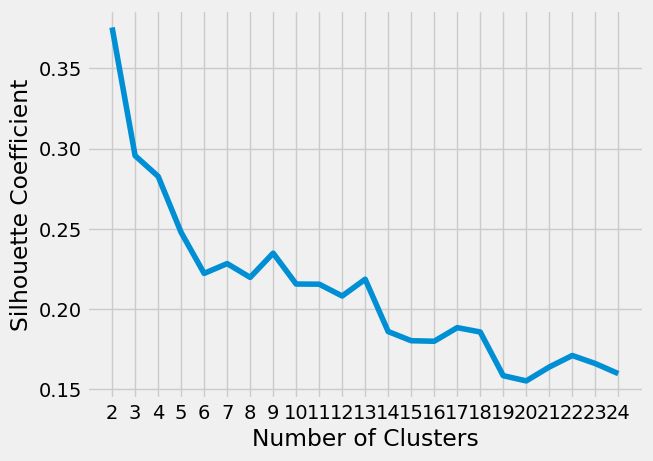

In [7]:
def plot_silhouette_scores(data, start, end, step):
  # A list holds the silhouette coefficients for each k
  silhouette_coefficients = []

  formated_data = data

  sse = {}
  # Notice you start at 2 clusters for silhouette coefficient
  for k in range(start, end, step):
    kmeans = KMeans(n_clusters=k, n_init=2, max_iter=1000)
    kmeans.fit(formated_data)
    score = silhouette_score(formated_data, kmeans.labels_)
    silhouette_coefficients.append(score)
    sse[k] = kmeans.inertia_

  plt.style.use("fivethirtyeight")
  plt.plot(range(start, end, step), silhouette_coefficients)
  plt.xticks(range(start, end, step))
  plt.xlabel("Number of Clusters")
  plt.ylabel("Silhouette Coefficient")
  plt.show()

  plt.plot(list(sse.keys()), list(sse.values()))
  plt.xlabel("Number of cluster")
  plt.ylabel("SSE")
  plt.show()



formated_data = np.vstack(X_train['embeddings'])
temp_data = []
for index, row in enumerate(formated_data):
  temp_data.append(np.concatenate((formated_data[index], [X_train['height'].values[index]], [X_train['weight'].values[index]])))
  #formated_data[index] = np.append(formated_data[index], X_train['weight'].values[index])
data = np.array(temp_data)
plot_silhouette_scores(data, 2, 25, 1)

The extremely low silhouette score implies there is a lot of overlap in classification of values. There might have to be some more data massaging in order to get this value higher

In [8]:
SELECTED_CLUSTERS = 3

In [9]:
# use the number of clusters found to be the best in graph above
kmeans = KMeans(n_clusters=SELECTED_CLUSTERS, n_init = 5)
#labels = kmeans.fit_predict(np.array(X_train[['embeddings', 'height', 'weight']]).reshape(-1, 1))
labels = kmeans.fit_predict(data)

X_train['label'] = labels

In [10]:
# show the top words for each cluster that was created
def get_top_features_cluster(X_train):
    data = X_train[X_train['label'] == 14]
    for index, row in data.iterrows():
        print("")
        print("player name: {}", row['player_name'])
        print(row['report'])
        
    

get_top_features_cluster(X_train)

In [11]:
import plotly.express as px

print(X_train.columns)
print(X_train.head())

#visualize mappings via treemap
result_summary = pd.pivot_table(X_train, index=['label', 'player_name'],  aggfunc='count').reset_index().rename(columns={'draft_position':'count'})
result_treemap = result_summary
fig = px.treemap(result_treemap,path=['label', 'player_name'],values='count')
fig.show()

Index(['team', 'player_name', 'draft_position', 'height', 'weight',
       'player_position', 'report', 'embeddings', 'label'],
      dtype='object')
     team         player_name  draft_position    height    weight  \
184    25        Dominik Bokk              25  0.130656 -0.738206   
28      4       Gleb Trikozov              60  0.130656 -0.144267   
104     3  John-Jason Peterka              34 -0.783999  0.317686   
214    29     Erik Brannstrom              15 -1.698655 -0.540227   
267    31      Lucas Johansen              28  0.473652 -0.775163   

     player_position                                             report  \
184                4   is one of the most interesting players for me...   
28                 3   is a talented winger. he displays great indiv...   
104                4   was a tough player to evaluate this season, a...   
214                1   is a favorite of mine relative to the opinion...   
267                1   took huge steps forward in his second

c:\Users\Ryan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



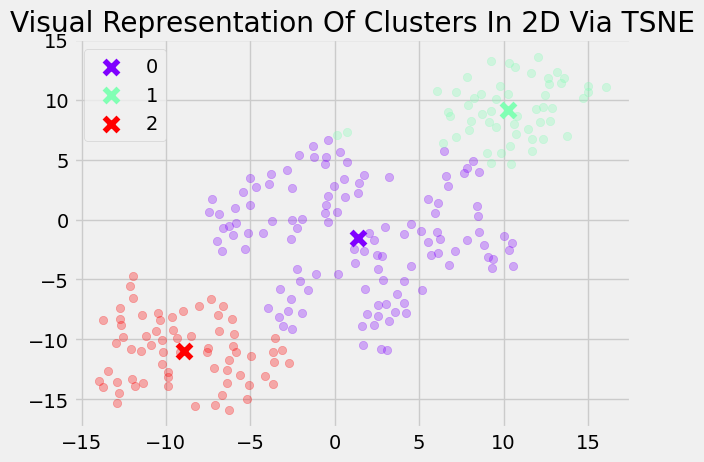

In [12]:
tsne = TSNE(n_components=2, learning_rate=200)
#data = X_train['embeddings'].values
vis_dims2 = tsne.fit_transform(data)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

color = cm.rainbow(np.linspace(0, 1, len(X_train.label.unique())))
for category, color in enumerate(color):
    xs = np.array(x)[X_train.label == category]
    ys = np.array(y)[X_train.label == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100, label=category)
plt.title("Visual Representation Of Clusters In 2D Via TSNE")
plt.legend()

In [160]:

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_train[['player_position', 'draft_position', 'label']], X_train['team'], test_size=0.33)
lr = LinearRegression()
lr.fit(X_train_lr, y_train_lr)

print(f"Linear Regression Score: {lr.score(X_test_lr, y_test_lr)}")



Linear Regression Score: -0.03634280758617181
